### Business goal
In order to facilitate public health, based on food nutritional data, propose an idea and create the corresponding algorithm (build an application).

 - data source: https://world.openfoodfacts.org/
 - data description: https://world.openfoodfacts.org/data/data-fields.txt
 - data reference : https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/notre-action/#tabs
 - project decription: 
https://openclassrooms.com/fr/paths/164/projects/628/assignment

-----
### My process:
1. ideation
2. data pre-processing (data cleansing and transformation)
3. data modeling and algorithm deployment in business

NB: this notebook deals with the data *cleaning and transformation*, supported by data *visualisation*. For further modeling and deployment, ref next notebook. 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
import missingno as msno

In [53]:
Food = pd.read_csv('openfoodfacts.csv',  sep='\t')   
food=Food.T
food.head(1)

,0,1,2,3,4,5,6,7,8,9,...,320762,320763,320764,320765,320766,320767,320768,320769,320770,320771
code,3087,4530,4559,16087,16094,16100,16117,16124,16193,16513,...,9908278636246,99111250,9918,9935010000003,99410148,9948282780603,99567453,9970229501521,9980282863788,999990026839


### My solution proposal 
Create an scoring algorithm for **Light Food Score**. Hereby the eventual features for this algorithm.

- low energy_100g, 
- low saturated-fat_100g  
- low sugars_100g, 
- high fiber_100g, 
- high vitamins (no-mandatory)
- high nutrition-score-fr  (no-mandatory)
----

we notice that most of criterias for Light Food Score are also indicators in Nutri-Score calculus formula. 

**Nutri-score**:https://www.santepubliquefrance.fr/en/nutri-score
- Calories (KJ)
- Saturated fatty acids (g)
- Sugars (g)
- Fibres (g)
- *Total fat (no mandatory)*
- *Proteins (g)*
- *Salt (g)* (no mandatory)
- *Sodium (if indicated directly) (mg)* (IF NOT, Sodium =ROUND(Salt/2,5*1000;0))
- *Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils %*

In [3]:
#Vitamins: Given the types of V are exclusive one another, we can make the sum of all the vitamins into one.

Food['vitamins'] = Food[['vitamin-c_100g', 'vitamin-a_100g','vitamin-d_100g','vitamin-e_100g','vitamin-k_100g',
                         'vitamin-b1_100g','vitamin-b2_100g','vitamin-b6_100g','vitamin-b9_100g','vitamin-b12_100g',
                         'vitamin-pp_100g', 'biotin_100g','pantothenic-acid_100g']].abs().sum(axis=1, skipna=True)

# sum of 13 types of vitamin
Food.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,vitamins
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,0.0214


In [4]:
print('product_name values', Food.product_name.values.shape)
print('how many unique product_name:',Food.product_name.unique().shape)
print('nb of null in product_name:', Food.product_name.isna().sum())

product_name values (320772,)
how many unique product_name: (221348,)
nb of null in product_name: 17762


In [5]:
print('So the amount of duplicates in product_name:', 
      (320772 - Food.product_name.isna().sum() - Food.product_name.unique().shape[0])/2)

So the amount of duplicates in product_name: 40831.0


In [6]:
print('So the amount of duplicates in code:', 
      (320772 - Food.code.isna().sum() - Food.code.unique().shape[0])/2)

So the amount of duplicates in code: 55.0


In [7]:
print(Food.categories_fr.unique().shape)
print(Food.created_t.unique().shape)
print(Food.last_modified_t.unique().shape)
print('how many unique code:',Food.code.unique().shape[0])
print('how many unique product_name:', Food.product_name.unique().shape[0])
print('how many values in vitamins:', Food.vitamins.shape)
print('how many values in last_modified_t:',Food.last_modified_t.shape)
print(Food.shape)
#print(Food.code.values[100:-1])

(21153,)
(189637,)
(180639,)
how many unique code: 320639
how many unique product_name: 221348
how many values in vitamins: (320772,)
how many values in last_modified_t: (320772,)
(320772, 163)


 [code] has the most unique values in Food - 320639 over 320772, so we can define roughly code as primary key.

In [8]:
# For that we need to ensure that picked indicators have as less NaN as possible 
# sort by % of NaN value by column 

na_percent = food.isna().mean(axis=1)
na_percent =pd.DataFrame(na_percent)
na_percent.sort_values(0)

,0
last_modified_t,0.000000
last_modified_datetime,0.000000
creator,0.000006
created_t,0.000009
created_datetime,0.000028
code,0.000072
url,0.000072
states,0.000143
states_tags,0.000143
states_fr,0.000143


<AxesSubplot:>

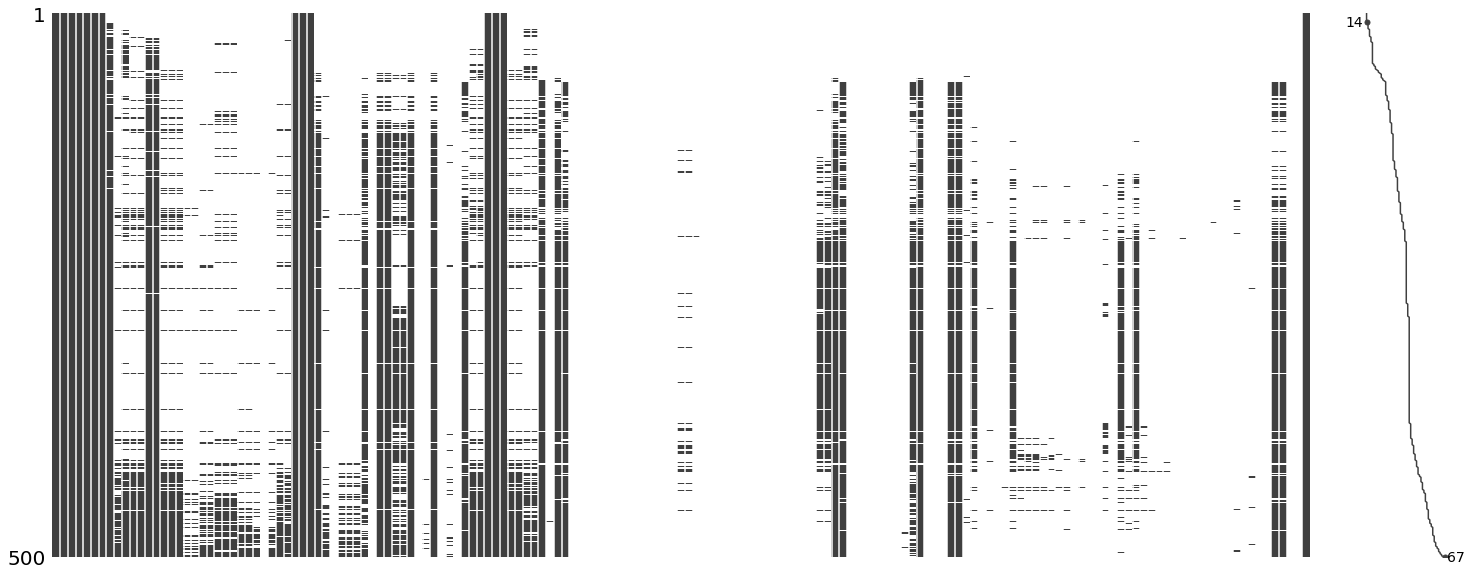

In [9]:
# plot null 
msno.matrix(Food.sample(500), sort='ascending')
#nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
#The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

<AxesSubplot:>

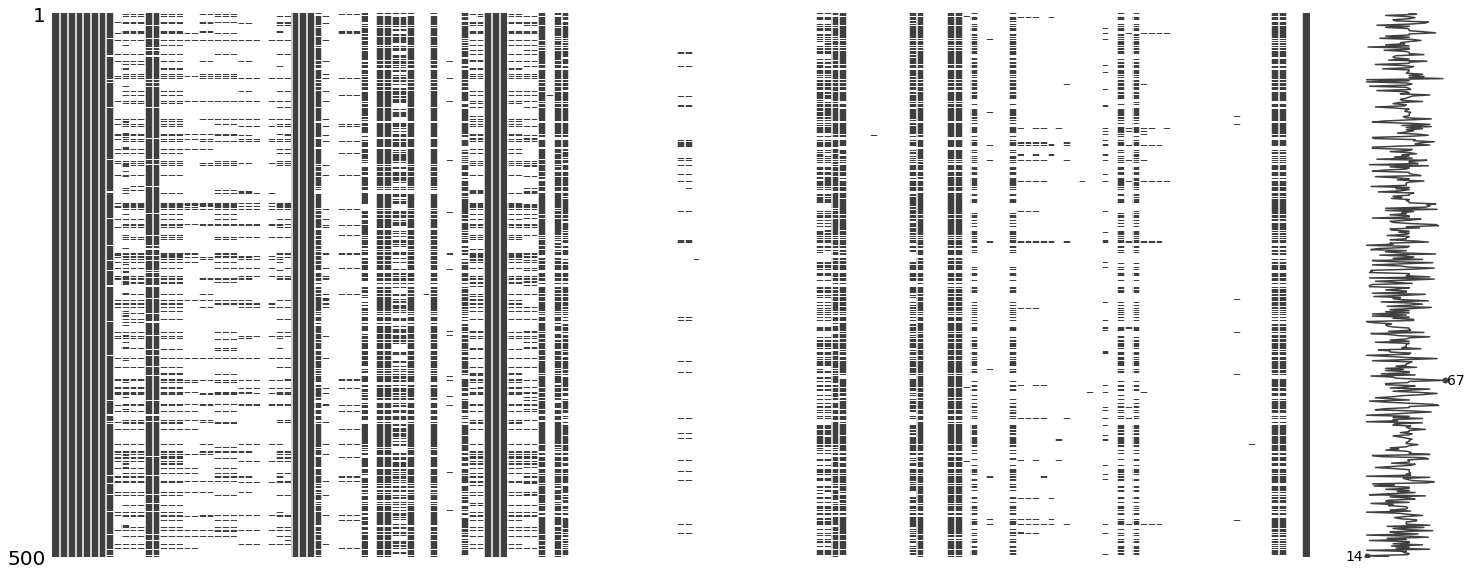

In [10]:
# sort n plot null 
sorted_data = msno.nullity_sort(Food, sort='descending') # or sort='ascending'
msno.matrix(sorted_data.sample(500))

<AxesSubplot:>

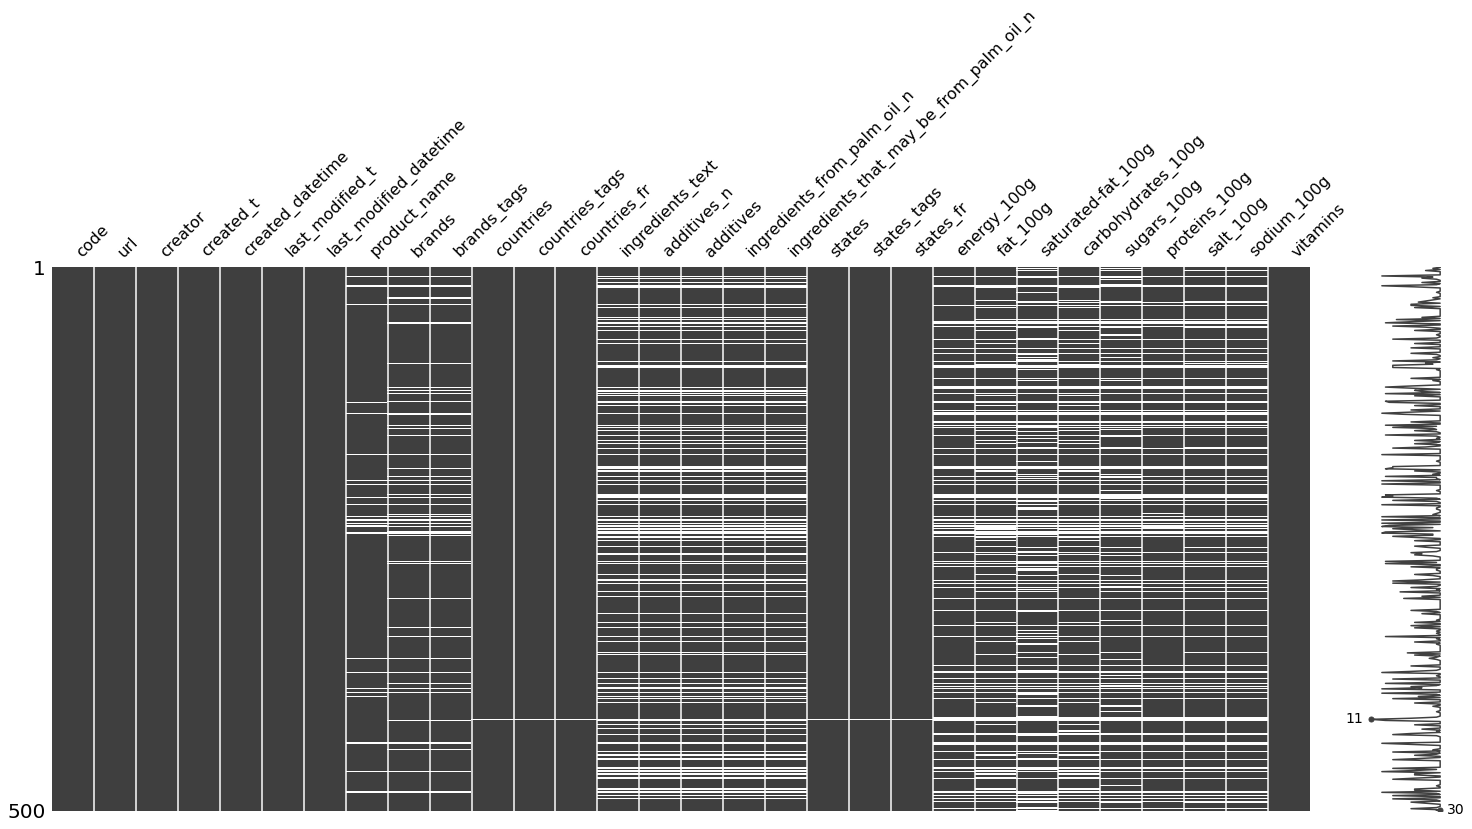

In [11]:
# filter n plot null according to filtering criteria
filtered_data = msno.nullity_filter(Food, filter='top', n=30, p=.7) # or filter='top'
msno.matrix(filtered_data.sample(500))

#filter=bottom, then p=0.9 makes sure that our columns are at most 90% complete; if filter=top we get columns which are at least 90% complete.

In [12]:
#msno.matrix(Food.sample(1000), filter= 'top', n=15, p=0.5,  sort='ascending')

<AxesSubplot:>

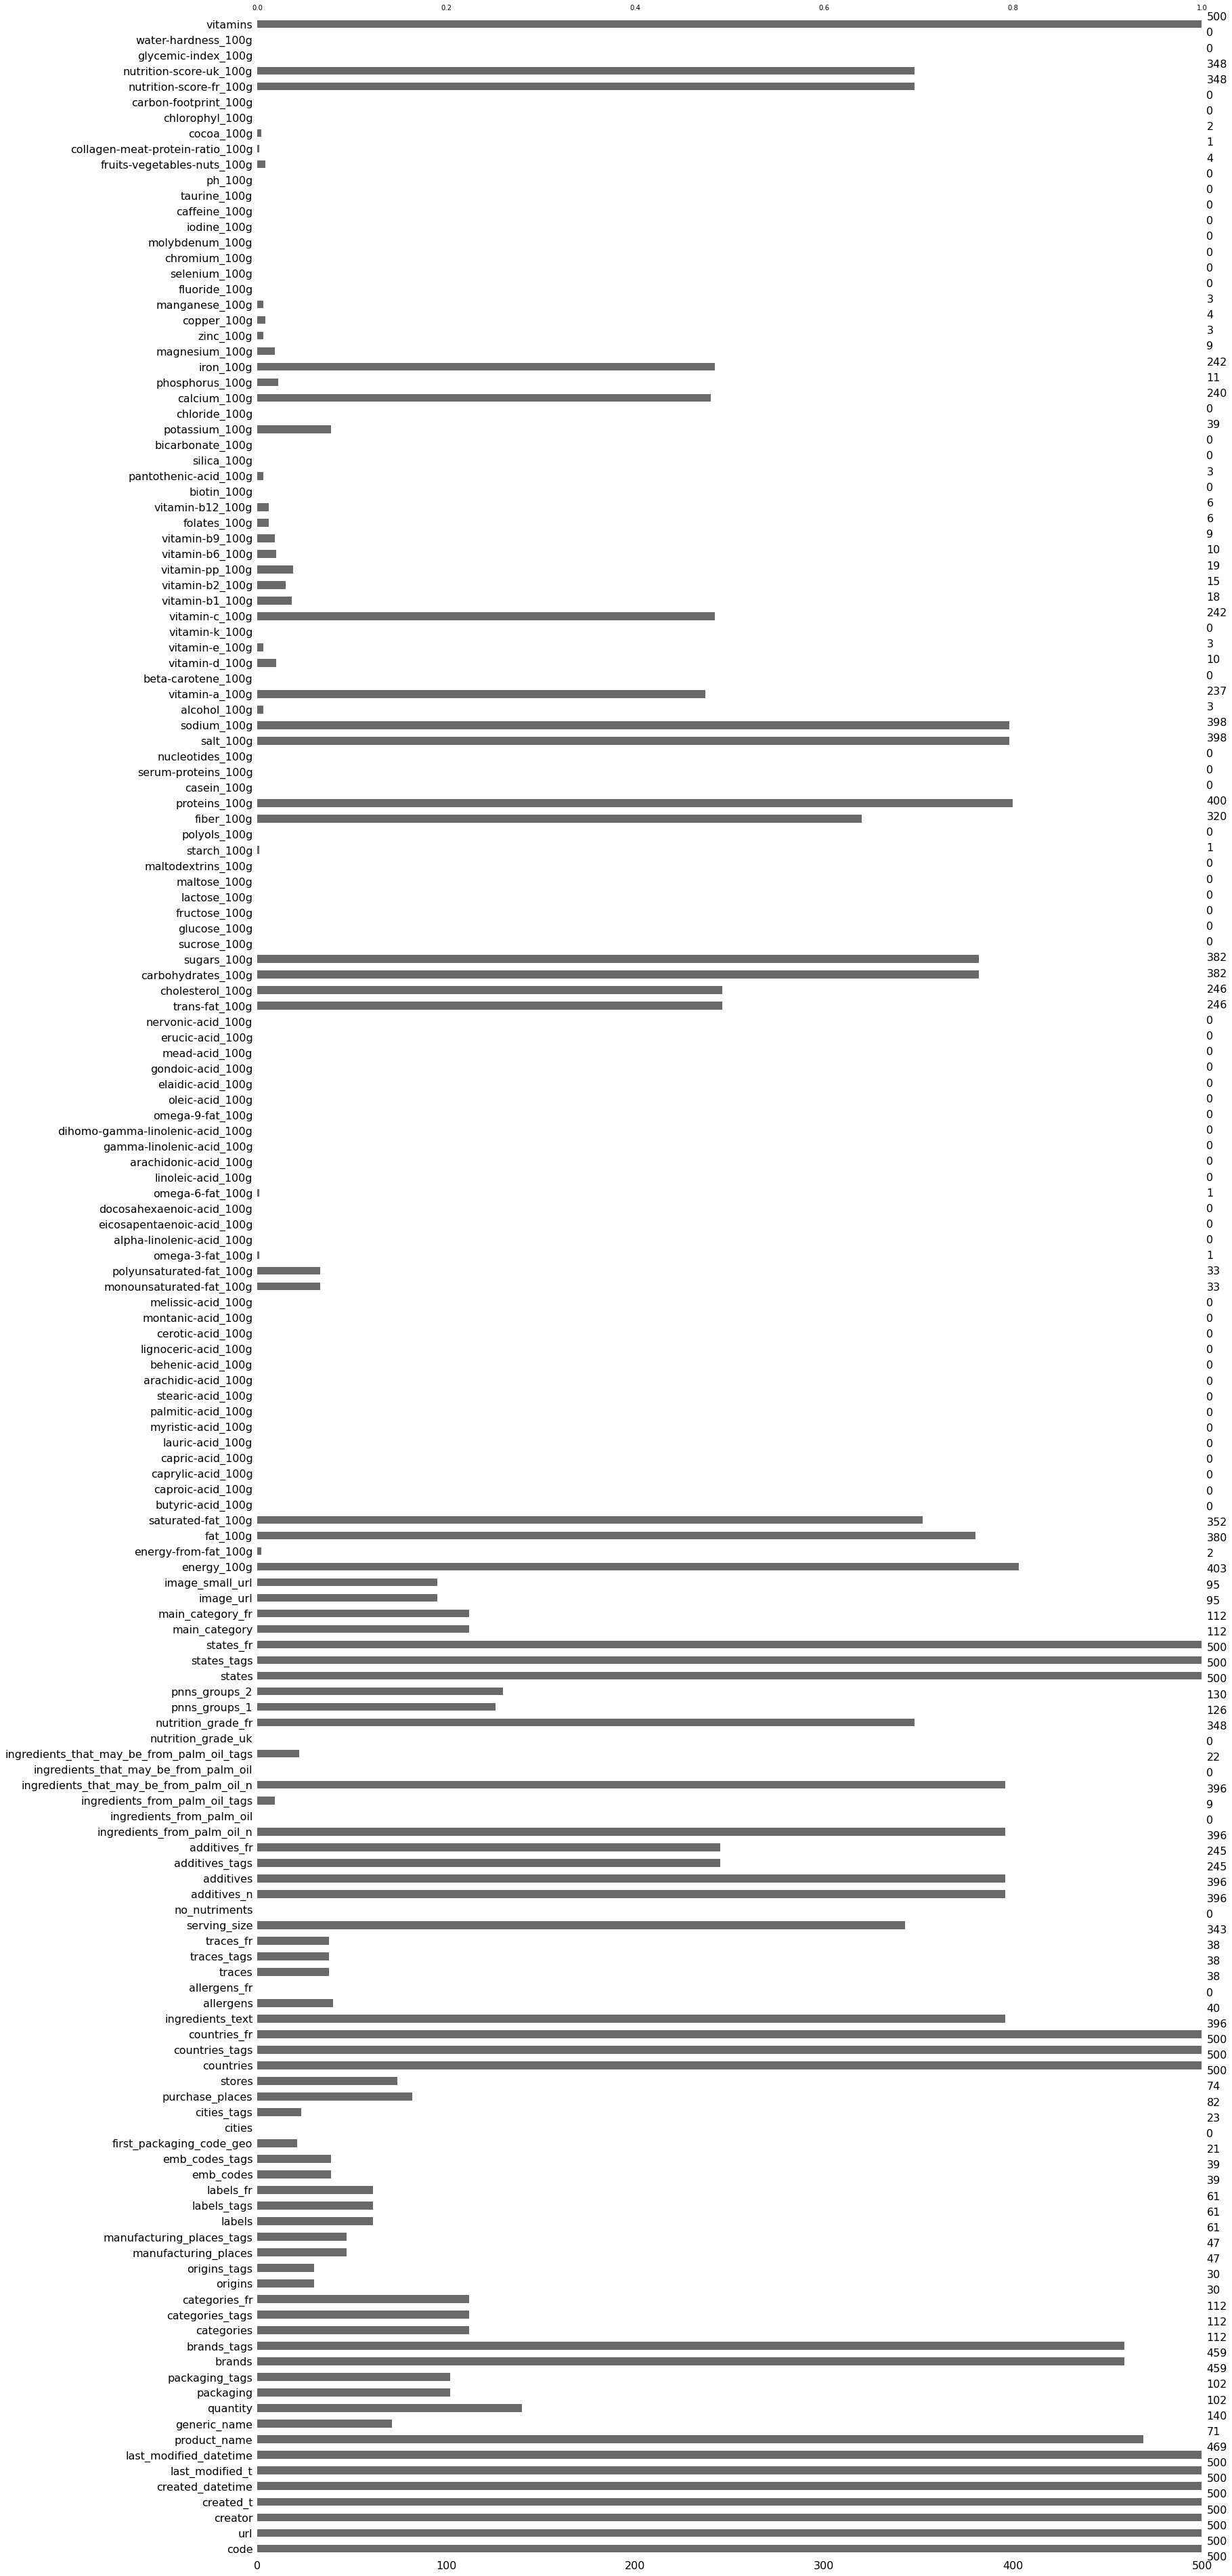

In [14]:
msno.bar(Food.sample(500))

In [15]:
len(Food.main_category.unique())
print(Food.main_category.unique()[:10])

[nan 'fr:filet-de-boeuf' 'en:fresh-vegetables' 'en:pastries' 'en:breads'
 'fr:boulange' 'en:plant-based-foods-and-beverages' 'fr:root-bier'
 'fr:sables' 'en:meals']


In [16]:
ProductGroup=Food.groupby(by='product_name').count().sort_values('code', ascending = False)#.reset_index()
print(ProductGroup.info())
print(ProductGroup.index)
ProductGroup.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 221347 entries, Ice Cream to Belgique,France,Suisse
Columns: 162 entries, code to vitamins
dtypes: int64(162)
memory usage: 275.3+ MB
None
Index(['Ice Cream', 'Extra Virgin Olive Oil', 'Potato Chips',
       'Premium Ice Cream', 'Tomato Ketchup', 'Beef Jerky', 'Pinto Beans',
       'Popcorn', 'Cookies', 'Salsa',
       ...
       'Gelato Coconut Fudge', 'Gelato Creamy Tiramisu',
       'Gelato Dark Chocolate Truffle', 'Gelato E Sorbetto',
       'Gelato Fiasco, Gelato, The Big County Brownie', '🍺', 'Belgique,France',
       'France,Suisse', 'France', 'Belgique,France,Suisse'],
      dtype='object', name='product_name', length=221347)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,generic_name,quantity,packaging,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,vitamins
product_name,,,,,,,,,,,,,,,,,,,,,
🍺,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"Belgique,France",0,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
"France,Suisse",0,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
France,0,0,20,17,14,20,20,19,18,0,...,0,0,0,0,0,0,0,0,0,20
"Belgique,France,Suisse",0,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
ProductGroup.head(1)
ProductGroup.mode()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,generic_name,quantity,packaging,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,vitamins
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1


We observe from the ProductGroup & CodeGroup that: 

    - 1 unique product_name may have 0 to 410 corresponding codes 
    - 1 code can have 0 - 2 corresponding product_names


In [18]:
CodeGroup=Food.groupby(by='code').count().sort_values('product_name', ascending = False) #.reset_index()
CodeGroup.head()

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,vitamins
code,,,,,,,,,,,,,,,,,,,,,
76186000028,2,2,2,2,2,2,2,1,1,1,...,0,0,0,0,0,2,2,0,0,2
609962037,2,2,2,2,2,2,2,0,0,0,...,0,0,0,0,0,2,2,0,0,2
688267155079,2,2,2,2,2,2,2,0,0,0,...,0,0,0,0,0,2,2,0,0,2
16571910310,2,2,2,2,2,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2
16073123454,2,2,2,2,2,2,2,0,0,0,...,0,0,0,0,0,2,2,0,0,2


In [19]:
CodeGroup.mode()

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,vitamins
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [20]:
Food.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,vitamins
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Create new df with selected columns

In [21]:
df = Food[['code','product_name','categories_fr', 'countries_fr', 'energy_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g',
           'vitamins','nutrition-score-fr_100g','nutrition_grade_fr']].rename({'saturated-fat_100g': 'saturatedfat', 'nutrition-score-fr_100g': 'nutriscore', 'nutrition_grade_fr':'nutrigrade','energy_100g':'energy', 'sugars_100g':'sugars', 'fiber_100g':'fiber','categories_fr':'category'}, axis=1)

print(df.info())
print(df.isna().mean())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   code          320749 non-null  object 
 1   product_name  303010 non-null  object 
 2   category      84411 non-null   object 
 3   countries_fr  320492 non-null  object 
 4   energy        261113 non-null  float64
 5   saturatedfat  229554 non-null  float64
 6   sugars        244971 non-null  float64
 7   fiber         200886 non-null  float64
 8   vitamins      320772 non-null  float64
 9   nutriscore    221210 non-null  float64
 10  nutrigrade    221210 non-null  object 
dtypes: float64(6), object(5)
memory usage: 26.9+ MB
None
code            0.000072
product_name    0.055373
category        0.736850
countries_fr    0.000873
energy          0.185986
saturatedfat    0.284370
sugars          0.236308
fiber           0.373742
vitamins        0.000000
nutriscore      0.310382
nutrigrad

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
0,3087,Farine de blé noir,NaN,France,NaN,NaN,NaN,NaN,0.0000,NaN,NaN
1,4530,Banana Chips Sweetened (Whole),NaN,États-Unis,2243.0,28.57,14.29,3.6,0.0214,14.0,d
2,4559,Peanuts,NaN,États-Unis,1941.0,0.00,17.86,7.1,0.0000,0.0,b
3,16087,Organic Salted Nut Mix,NaN,États-Unis,2540.0,5.36,3.57,7.1,0.0000,12.0,d
4,16094,Organic Polenta,NaN,États-Unis,1552.0,NaN,NaN,5.7,0.0000,NaN,NaN


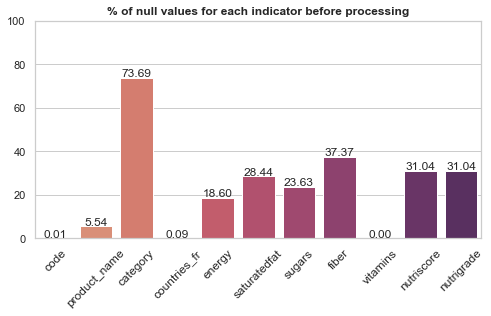

In [22]:
plt.figure(figsize=(8,4))
sns.set(style='whitegrid')
ax = sns.barplot(x= df.columns, y= df.isna().mean()*100, palette= 'flare')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4), 
                   textcoords = 'offset points')
plt.title('% of null values for each indicator before processing', fontsize=12, fontweight="bold")
plt.xticks(fontsize=12, rotation=45)
plt.ylim(0,100)
plt.show()

## Pre-processing (cleaning, transformation)

In [23]:
# 1. Keep only the rows where countries_fr contains 'France' 

df= df[df['countries_fr'].str.contains("France",na=False)]   # na = False : drop null rows when selection . na=True: don't drop null rows when selection

#hi2= df.query('countries_fr.str.contains("France")').fillna(False)
print(df.info())
#print(df.countries_fr.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98440 entries, 0 to 320770
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code          98440 non-null  object 
 1   product_name  91247 non-null  object 
 2   category      61955 non-null  object 
 3   countries_fr  98440 non-null  object 
 4   energy        64593 non-null  float64
 5   saturatedfat  62375 non-null  float64
 6   sugars        62515 non-null  float64
 7   fiber         45723 non-null  float64
 8   vitamins      98440 non-null  float64
 9   nutriscore    61415 non-null  float64
 10  nutrigrade    61415 non-null  object 
dtypes: float64(6), object(5)
memory usage: 9.0+ MB
None


In [24]:
# doublons dans product_name 

nutella = Food[Food['product_name']=="nutella"][['code', 'product_name','generic_name', 'quantity','created_t']]
nutella

,code,product_name,generic_name,quantity,created_t
258995,4008400401225,nutella,Nuss-Nugat-Creme,880 g,1425839637
258997,4008400401829,nutella,Nuss-Nugat-Creme,1000 g,1443523893
258998,4008400401928,nutella,Nuss-Nugat-Creme,800 g,1419944885
300382,78871267,nutella,NaN,750 gr,1473970452
301134,8000500087787,nutella,NaN,NaN,1415015090
304138,80135876,nutella,Crema de cacao y avellanas,400 g,1422446383
305503,80751151,nutella,Nuss-Nugat-Creme,15 g,1443521493


In [25]:
#2.1 verification of null in every column
print(df.isna().sum(axis=0))
print(df.isna().mean(axis=0))

code                0
product_name     7193
category        36485
countries_fr        0
energy          33847
saturatedfat    36065
sugars          35925
fiber           52717
vitamins            0
nutriscore      37025
nutrigrade      37025
dtype: int64
code            0.000000
product_name    0.073070
category        0.370632
countries_fr    0.000000
energy          0.343834
saturatedfat    0.366365
sugars          0.364943
fiber           0.535524
vitamins        0.000000
nutriscore      0.376117
nutrigrade      0.376117
dtype: float64


0 null in "code"

In [26]:
# 2.1 duplicates in code column
df.duplicated(subset=['code'],keep=False).sum() #By setting keep on False, all duplicates are True. 4*2

8

In [27]:
print('duplicates in "code" column:', df['code'].duplicated().sum())
df[df['code'].duplicated()]

duplicates in "code" column: 4


,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
519,24600,NaN,NaN,France,NaN,NaN,NaN,NaN,0.0,NaN,NaN
9892,11778,All Butter Reduced Fat Stem Ginger Cookies,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Coo...","France,Royaume-Uni",1809.0,7.0,35.7,2.5,0.0,18.0,d
120240,635646,Chargrilled Vegetable & Basil Pesto,"Plats préparés,Pizzas tartes salées et quiches...","France,Royaume-Uni",859.0,1.9,3.8,2.0,0.0,1.0,b
134825,722810,Sea Salt & Balsamic Vinegar hand cooked Crisps,"Snacks salés,Apéritif,Chips et frites,Chips,Ch...","France,Royaume-Uni",2173.0,3.2,1.9,4.6,0.0,12.0,d


In [28]:
df[['code','product_name']].duplicated().sum()

0

In [29]:
# 2.2 drop duplicates based on ['code'], boz code is primary key / dédoublonnage 
#df=df.dropna(subset=['code'])
df=df.drop_duplicates(subset=['code'])

# suppression des duplicatas en gardant les versions les mieux remplies (la version en haut a moins de NaN)
df = df.drop_duplicates(['code', 'product_name'], keep='first') 
print(df.info())
#df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98436 entries, 0 to 320770
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code          98436 non-null  object 
 1   product_name  91244 non-null  object 
 2   category      61952 non-null  object 
 3   countries_fr  98436 non-null  object 
 4   energy        64590 non-null  float64
 5   saturatedfat  62372 non-null  float64
 6   sugars        62512 non-null  float64
 7   fiber         45720 non-null  float64
 8   vitamins      98436 non-null  float64
 9   nutriscore    61412 non-null  float64
 10  nutrigrade    61412 non-null  object 
dtypes: float64(6), object(5)
memory usage: 9.0+ MB
None


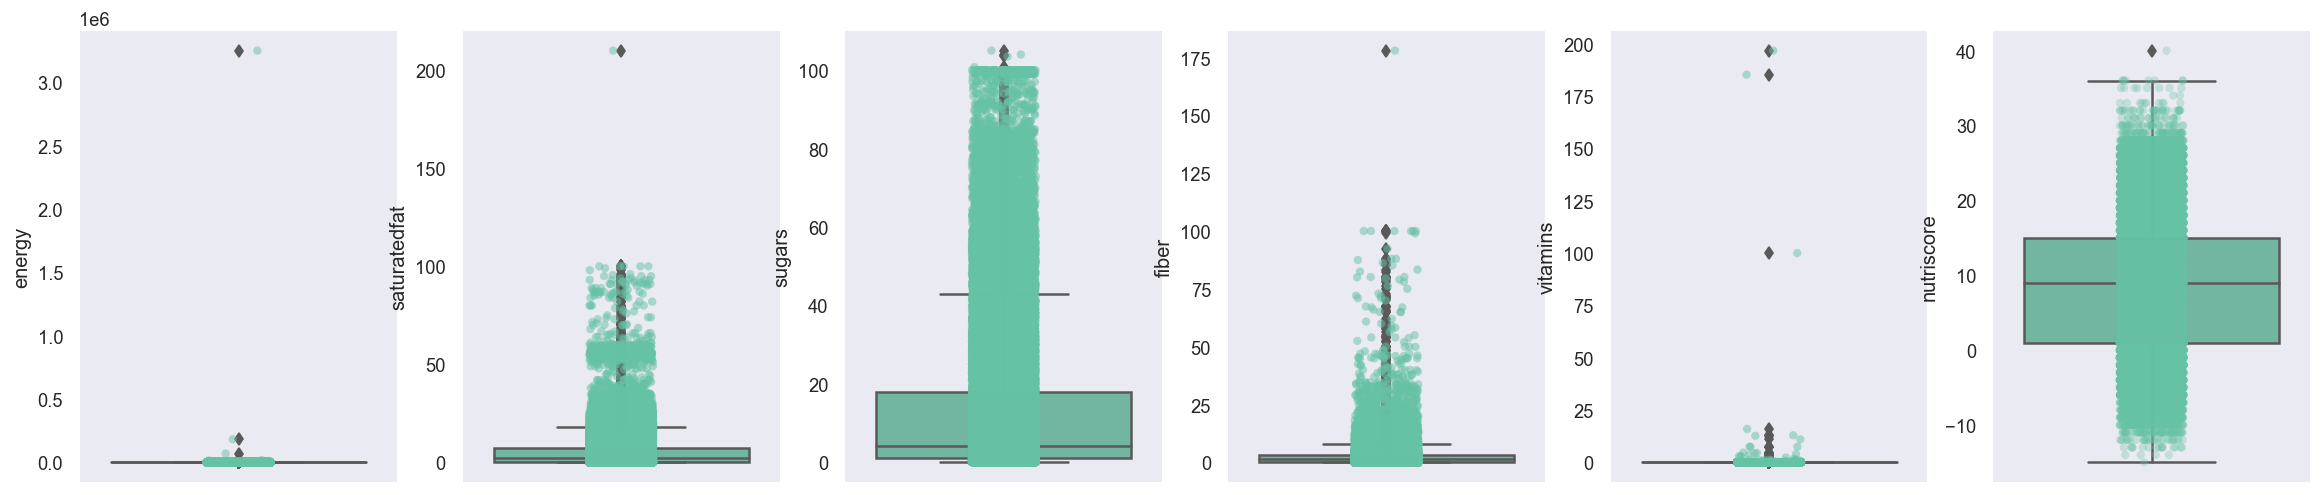

In [30]:
plt.figure(figsize= (24,5), dpi=120)
sns.set(style="dark")

plt.subplot(1,6,1)
ax=sns.boxplot(y="energy", data=df, palette="Set2")
ax=sns.stripplot(y="energy", data=df, palette="Set2", alpha=0.5)

plt.subplot(1,6,2)
ax=sns.boxplot(y="saturatedfat", data=df, palette="Set2")
ax=sns.stripplot(y="saturatedfat", data=df, palette="Set2", alpha=0.5)

plt.subplot(1,6,3)
ax=sns.boxplot(y="sugars", data=df, palette="Set2")
ax=sns.stripplot(y="sugars", data=df, palette="Set2", alpha=0.5)

plt.subplot(1,6,4)
ax=sns.boxplot(y="fiber", data=df, palette="Set2")
ax=sns.stripplot(y="fiber", data=df, palette="Set2", alpha=0.5)

plt.subplot(1,6,5)
ax=sns.boxplot(y="vitamins",  data=df, palette="Set2")
ax=sns.stripplot(y="vitamins",  data=df, palette="Set2", alpha=0.5)

plt.subplot(1,6,6)
ax=sns.boxplot(y="nutriscore",  data=df, palette="Set2")
ax=sns.stripplot(y="nutriscore",  data=df, palette='Set2', alpha=0.3)
plt.show()

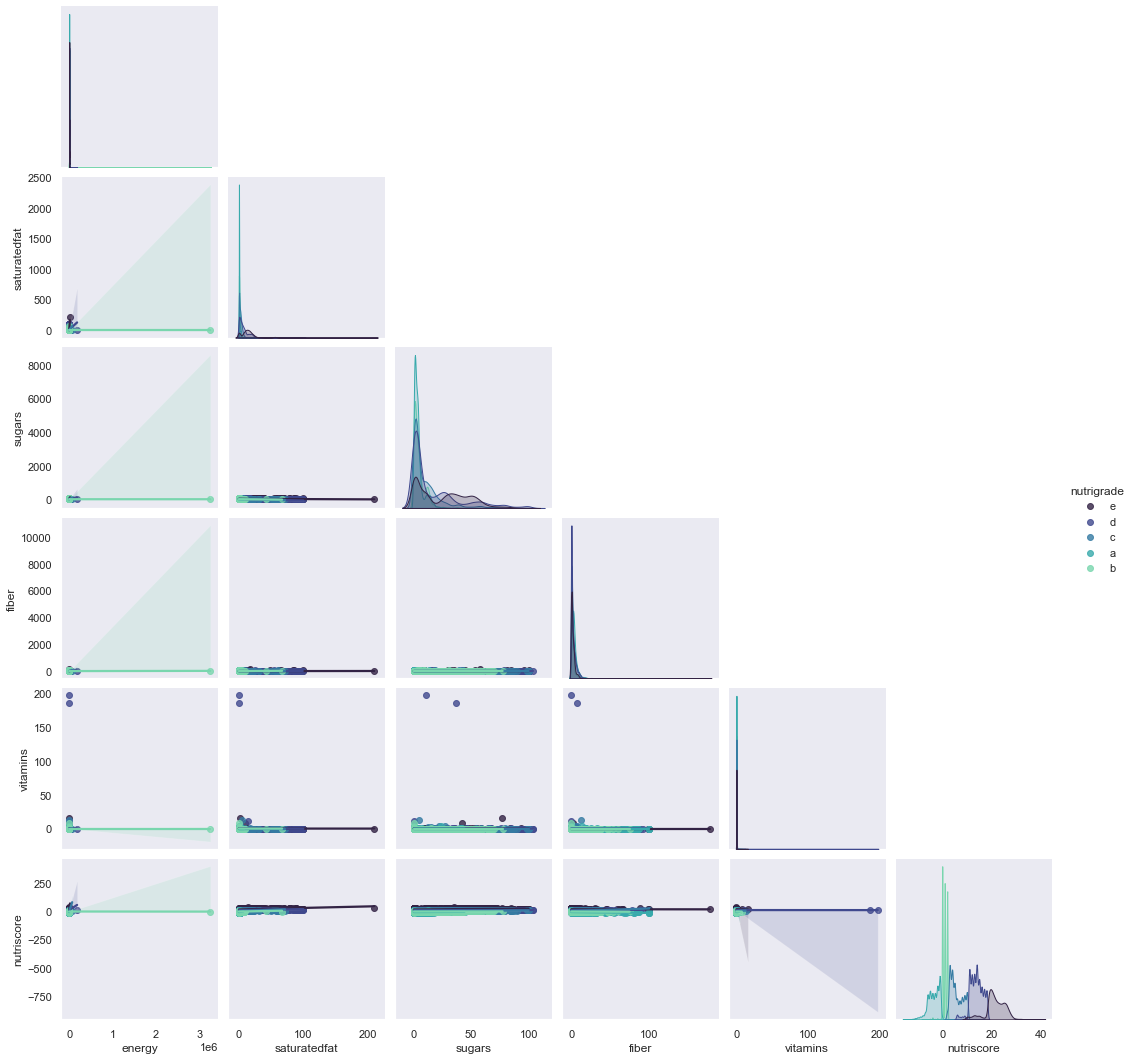

In [31]:
sns.pairplot(data=df, hue="nutrigrade", diag_kind= "kde", kind="reg", palette='mako', corner= True)

In [32]:
df.describe()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
count,6.459000e+04,62372.000000,62512.000000,45720.000000,98436.000000,61412.000000
mean,1.171532e+03,5.423763,13.432775,2.559240,0.006676,8.683124
std,1.283620e+04,8.531269,19.087774,4.634929,0.923874,9.046211
min,0.000000e+00,0.000000,-0.100000,0.000000,0.000000,-15.000000
25%,4.270000e+02,0.300000,1.000000,0.000000,0.000000,1.000000
50%,1.035000e+03,2.000000,4.100000,1.365000,0.000000,9.000000
75%,1.649000e+03,7.400000,17.800000,3.200000,0.000000,15.000000
max,3.251373e+06,210.000000,105.000000,178.000000,196.707879,40.000000


- **energy, saturatedfat, fiber, vitamins** have large amount of outliers (valeurs aberrantes) on max side: big difference between 75% quantile and max.
- Presence of negative values in sugars and nutriscore: it's normal to have negative values in nutriscore, but for **sugars** not normal.

Need to clean. 

In [33]:
#df=df.drop(['countries_fr'],axis=1).set_index('code')
#df=df.groupby(['category','nutrigrade','product_name'], axis=1)
#df.head(1)

In [34]:
df.loc[(df.sugars>=df.sugars.min()) & (df.sugars<=df.sugars.mean())].sort_values('sugars', ascending=True)[:5]

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
195761,3161712000928,Caprice des dieux,"Produits laitiers,Fromages,Fromages de vache",France,1379.0,21.0,-0.1,NaN,0.000,15.0,d
269878,5000169106181,Grana Padano,NaN,France,1623.0,18.0,0.0,0.0,0.000,14.0,d
263920,42102120,Airwaves Cherry Menthol,"Snacks sucrés,Confiseries,Chewing-gum,Chewing-...",France,660.0,0.0,0.0,0.0,0.000,1.0,b
228618,3366321052409,"St Hubert Bio (Doux, Tartine et Cuisine), (58 ...","Aliments et boissons à base de végétaux,Alimen...",France,2146.0,25.0,0.0,NaN,0.007,14.0,d
263930,42113188,"Wrigley's Gum (extra, Professional, Strong Min...",NaN,France,598.0,0.0,0.0,NaN,0.000,1.0,b


In [35]:
# 3. convert negative values in "sugars" (and eventually in other columns apart from nutriscore) into positive

df[["energy","saturatedfat","sugars","fiber", "vitamins"]] = df[["energy","saturatedfat","sugars","fiber", "vitamins"]].abs()
#df.sugars = df.sugars.abs()
df.describe()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
count,6.459000e+04,62372.000000,62512.000000,45720.000000,98436.000000,61412.000000
mean,1.171532e+03,5.423763,13.432778,2.559240,0.006676,8.683124
std,1.283620e+04,8.531269,19.087771,4.634929,0.923874,9.046211
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,4.270000e+02,0.300000,1.000000,0.000000,0.000000,1.000000
50%,1.035000e+03,2.000000,4.100000,1.365000,0.000000,9.000000
75%,1.649000e+03,7.400000,17.800000,3.200000,0.000000,15.000000
max,3.251373e+06,210.000000,105.000000,178.000000,196.707879,40.000000


#### trouble shooting : find the outliers in each column, and identify the right threshold for filtering 

In [36]:
df.loc[(df.vitamins>=df.vitamins.mean()) & (df.vitamins<=df.vitamins.max())].sort_values('vitamins', ascending=False)[:40]

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
67437,64100589940,Céréales rice krispies,"Aliments et boissons à base de végétaux,Alimen...",France,1640.0,0.00,10.70,0.00,196.707879,13.0,d
12998,16000275348,Lucky Charms,"Aliments et boissons à base de végétaux,Alimen...","France,États-Unis",1700.0,0.00,37.00,7.41,185.243587,14.0,d
195747,3160921610300,Juvamine Vitamine C500 à croquer sans sucres,Viatmine-c-en-comprimes,France,NaN,NaN,NaN,NaN,100.000000,NaN,NaN
177048,20008067,goodycao,Preparation-en-poudre-instantanee-pour-boisson...,France,1565.0,1.40,76.70,NaN,15.971017,21.0,e
231048,3401528535864,Centrum Men,Compléments alimentaires,France,NaN,NaN,NaN,NaN,12.952762,NaN,NaN
230270,3390390000115,Purée Amande Complete bio,"Aliments et boissons à base de végétaux,Alimen...",France,2753.0,4.90,4.60,12.00,12.700000,8.0,c
228608,3366321051976,St Hubert Oméga 3 demi-sel,"Aliments et boissons à base de végétaux,Alimen...",France,1849.0,14.00,0.00,0.10,11.000330,14.0,d
231030,3401272355749,Nutrilon Picot AR,Lait-en-poudre-pour-bebe,France,2023.0,9.20,41.90,2.80,7.596194,22.0,e
161015,853471004387,"Coconut Liquid Water Enhancer, Original",NaN,France,0.0,0.00,0.00,0.00,7.500000,0.0,b
163139,855461003240,Aeroshot Energy Green Apple,Produits-energisants,France,567.0,NaN,33.30,0.00,7.339000,NaN,NaN


In [37]:
#df= df.loc[df.vitamins<=100]

In [38]:
df.loc[(df.saturatedfat>=df.saturatedfat.mean()) & (df.saturatedfat<=df.saturatedfat.max())].sort_values('saturatedfat', ascending=False)[:100]

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
245311,3596710288755,mini choux goût fromage de chèvre - poivre,"Snacks salés,Apéritif,Biscuits apéritifs,Produ...",France,18700.0,210.00,22.70,0.0,0.000000,35.0,e
219970,3270190118800,Huile De Tournesol Végétale 2 Litre,NaN,France,3766.0,100.00,0.00,0.0,0.000000,20.0,e
283105,6091035082004,Eau,NaN,France,418.0,100.00,100.00,100.0,0.000000,24.0,e
275205,5158418187631,Végétaline (offre familiale),"Aliments et boissons à base de végétaux,Alimen...",France,3700.0,100.00,0.00,NaN,0.000000,15.0,d
177219,20022082,Frites & Fritures,"Aliments et boissons à base de végétaux,Alimen...",France,3700.0,100.00,0.00,NaN,0.000000,20.0,e
184439,26008028,Jog'Frit,"Aliments et boissons à base de végétaux,Alimen...",France,3700.0,100.00,0.00,NaN,0.000000,20.0,e
318627,9230000011527,"Boite Metallique Ronde, Bonbon, Rose, 20 cm Et...",NaN,France,623.0,99.00,7.00,0.0,0.000000,12.0,d
288249,76107191,Bonbons aux herbes,NaN,"France,Suisse",1004.0,98.00,0.00,0.0,0.000000,12.0,d
275815,5400101050372,Carrefour Bio,NaN,France,3707.0,96.00,0.50,0.0,0.000000,20.0,e
271532,5013635101818,Pure coconut oil,NaN,France,3761.0,95.50,0.00,0.0,0.000000,22.0,e


saturatedfat: https://www.heartuk.org.uk/low-cholesterol-foods/saturated-fat#:~:text=Per%20100g%20of%20food%20%E2%80%93%20low,fat%20is%205g%20or%20more

https://www.stylecraze.com/articles/foods-with-high-saturated-fats/

In [39]:
# df= df.loc[df.saturatedfat<=100]

In [40]:
# df.loc[df.fiber==df.fiber.max()]
df.loc[(df.fiber>=df.fiber.mean()) & (df.fiber<=df.fiber.max())].sort_values('fiber', ascending=False)[:200]

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
298897,7622210988768,Milka Schmunzelhase Alpenmilch 175G,NaN,France,2218.0,18.000,58.00,178.00,0.000000,22.0,e
285429,7340055304214,Marshall - Major Noir,NaN,France,21.0,5.000,5.00,100.00,0.000000,10.0,c
283105,6091035082004,Eau,NaN,France,418.0,100.000,100.00,100.00,0.000000,24.0,e
170118,883929140886,Harry Potter & The Deathly Hallows Radcliffe /...,Non alimentaire,France,4.0,0.000,0.00,100.00,0.000000,-10.0,a
244661,3590670000174,Noix sèches,NaN,France,0.0,0.000,0.00,100.00,0.000000,-5.0,a
273543,5051889553625,Le Hobbit : La Bataille Des Cinq Armés - Versi...,NaN,France,4.0,0.000,0.00,100.00,0.000000,-10.0,a
127525,698502500571,Savarez - Jeu De Cordes,NaN,France,4.0,0.100,0.10,100.00,0.000000,-10.0,a
225939,3333297304290,Fais Pas Ci,NaN,France,38.0,63.000,81.00,99.00,0.000000,25.0,e
244464,3583788522898,Isotonic Sport Drink,NaN,France,1523.0,0.000,78.20,92.40,0.000000,16.0,d
256886,4001686304792,Haribo Goldbären Dose 450G,NaN,France,4648.0,84.000,35.00,88.00,0.000000,32.0,e


Fiber contenance   https://www.otsuka.co.jp/en/health-and-illness/fiber/intake/foods-amount/ 

https://www.healthline.com/nutrition/22-high-fiber-foods#TOC_TITLE_HDR_21


In [41]:
# based on research on fiber contenance in various food, we can drop fiber >75g/100g
#df= df.loc[df.fiber<=75.00].sort_values('fiber', ascending=False)
#df.head(2)

In [42]:

df.loc[(df.energy>=df.energy.mean()) & (df.energy<=df.energy.max())].sort_values('energy', ascending=False)[:100]

#Fat has the highest calorie per gram of any macronutrient from food, which is 9 calories per gram. 
# So, 9 calories x 100 grams = 900 calories = 3770 KJ 
# we know from openfoodfacts that here the energy has unit KJ

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
212928,3257983143096,Pois cassés,Pois-casses,France,3251373.0,0.20,2.50,15.4,0.0000,0.0,b
249101,3661405001053,"Légume Noisettes Carottes, 500 Grammes, Marque...",NaN,France,182764.0,2.00,4.50,3.5,0.0000,12.0,d
219302,3270160689774,NaN,NaN,France,69292.0,0.01,11.50,3.4,0.0000,8.0,c
245311,3596710288755,mini choux goût fromage de chèvre - poivre,"Snacks salés,Apéritif,Biscuits apéritifs,Produ...",France,18700.0,210.00,22.70,0.0,0.0000,35.0,e
223318,3291960006127,Huiles vierge biologique de Colza - première p...,"Aliments et boissons à base de végétaux,Alimen...",France,15481.0,8.00,0.00,0.0,0.0000,10.0,c
178787,20233679,Halva with Almonds,"Snacks sucrés,Confiseries,Halvas,Pates-de-sesame",France,9983.0,7.80,32.00,NaN,0.0000,24.0,e
224442,3303640001404,Croûtons à l'ail,"Aliments et boissons à base de végétaux,Alimen...",France,9050.0,3.00,3.50,NaN,0.0000,19.0,e
218448,3267110002653,300G TARTINABLE a LA NOISETTE,NaN,France,7339.0,1.60,42.70,3.5,0.0000,16.0,d
250717,3700640470139,Gruyère France au lait cru (33% MG),"Produits laitiers,Fromages,Fromages de France,...",France,7029.0,21.00,0.50,NaN,0.0000,18.0,d
240071,3560070927296,Emmental français râpé au lait cru,"Produits laitiers,Fromages,Fromages à pâte pre...",France,6803.0,19.00,0.00,1.1,0.0000,16.0,d


In [43]:
#sns.displot(data=df, y= "energy", hue= "nutrigrade", kde=True)

In [44]:
df.nutriscore.unique()

array([ nan,  22.,  14.,  13.,  15.,  12.,   6.,  26.,  18.,  20.,  -2.,
         1.,  11.,  19.,   4.,   2.,   7.,  17.,   5.,  -4.,  25.,  -3.,
         0.,  23.,   3.,  16.,   9.,  24.,  21.,   8.,  -6.,  -1.,  10.,
        -5.,  29.,  35.,  27.,  28.,  -7.,  -9.,  36.,  32., -10.,  30.,
        -8.,  33.,  40., -11.,  31., -12.,  34., -13., -14., -15.])

In [45]:
df.head(1)

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
0,3087,Farine de blé noir,NaN,France,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [46]:
# 4. filter out outliers in columns : energy, saturatedfat, fiber, vitamins 

df = df.loc[(df.energy<=3770) & (df.saturatedfat<=100) &(df.fiber<=75) & (df.vitamins<=10)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45283 entries, 106 to 320763
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code          45283 non-null  object 
 1   product_name  45069 non-null  object 
 2   category      29308 non-null  object 
 3   countries_fr  45283 non-null  object 
 4   energy        45283 non-null  float64
 5   saturatedfat  45283 non-null  float64
 6   sugars        45195 non-null  float64
 7   fiber         45283 non-null  float64
 8   vitamins      45283 non-null  float64
 9   nutriscore    44674 non-null  float64
 10  nutrigrade    44674 non-null  object 
dtypes: float64(6), object(5)
memory usage: 4.1+ MB


In [47]:
df.describe()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
count,45283.000000,45283.000000,45195.000000,45283.000000,45283.000000,44674.000000
mean,1112.164404,4.918430,13.460442,2.505541,0.001928,7.588194
std,774.449452,8.212228,18.631867,4.131667,0.068610,9.036822
min,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,406.000000,0.300000,1.200000,0.000000,0.000000,0.000000
50%,1040.000000,1.600000,4.400000,1.330000,0.000000,7.000000
75%,1661.000000,6.200000,18.400000,3.200000,0.000000,14.000000
max,3770.000000,100.000000,104.000000,75.000000,7.596194,36.000000


In [48]:
# 5 . drop non necessary columns and set index 
#df= df.drop(['countries_fr'], axis=1).set_index(['code','category','nutrigrade','product_name'])
#df=df.dropna(thresh=5)
print(df.info())
print(df.isna().mean())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45283 entries, 106 to 320763
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code          45283 non-null  object 
 1   product_name  45069 non-null  object 
 2   category      29308 non-null  object 
 3   countries_fr  45283 non-null  object 
 4   energy        45283 non-null  float64
 5   saturatedfat  45283 non-null  float64
 6   sugars        45195 non-null  float64
 7   fiber         45283 non-null  float64
 8   vitamins      45283 non-null  float64
 9   nutriscore    44674 non-null  float64
 10  nutrigrade    44674 non-null  object 
dtypes: float64(6), object(5)
memory usage: 4.1+ MB
None
code            0.000000
product_name    0.004726
category        0.352781
countries_fr    0.000000
energy          0.000000
saturatedfat    0.000000
sugars          0.001943
fiber           0.000000
vitamins        0.000000
nutriscore      0.013449
nutrigrade      0.0134

,code,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
106,36252,Lion Peanut x2,NaN,"France,États-Unis",1883.0,12.5,57.5,2.5,0.0,22.0,e
190,10187319,Mini Confettis,NaN,France,1753.0,0.8,87.7,0.9,0.0,14.0,d


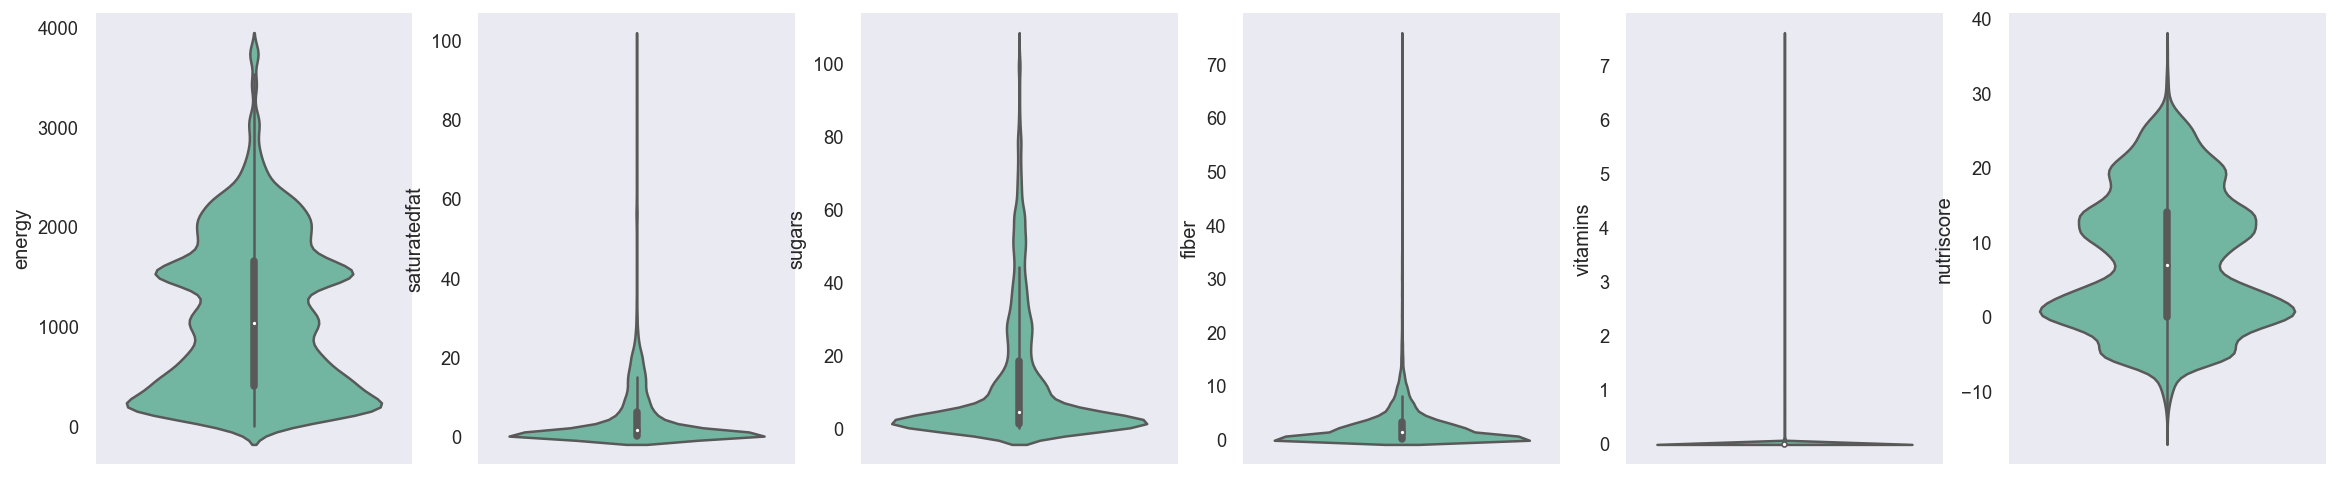

In [49]:
plt.figure(figsize= (24,5), dpi=120)
sns.set(style="dark")

plt.subplot(1,6,1)
ax=sns.violinplot(y="energy",
                 data=df, palette="Set2")

plt.subplot(1,6,2)
ax=sns.violinplot(y="saturatedfat", 
                 data=df, palette="Set2")

plt.subplot(1,6,3)
ax=sns.violinplot(y="sugars",
                 data=df, palette="Set2")

plt.subplot(1,6,4)
ax=sns.violinplot(y="fiber", 
                 data=df, palette="Set2")

plt.subplot(1,6,5)
ax=sns.violinplot(y="vitamins",  
                 data=df, palette="Set2")

plt.subplot(1,6,6)
ax=sns.violinplot(y="nutriscore",  
                 data=df, palette="Set2")
plt.show()

In [50]:
hi=df.reset_index().drop(['product_name','category'],axis=1)
hi.head(1)

,index,code,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
0,106,36252,"France,États-Unis",1883.0,12.5,57.5,2.5,0.0,22.0,e


Text(0.5, 1.0, 'correlation heatmap_imputed')

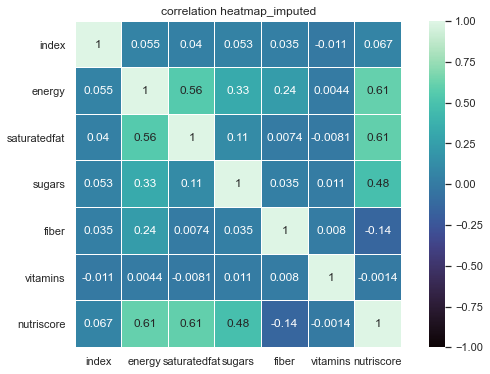

In [51]:
plt.figure(figsize = (10,6))
sns.heatmap(hi.corr(),
            linewidths=.01,  
            annot=True, 
            square=True,
            cmap='mako',
            vmax=1,
            vmin=-1)
plt.title('correlation heatmap_imputed')

In [52]:
df.to_csv('P3_openfoodfacts_cleaned_df.csv')